In this notebook, we'll be working on a classic problem: solving the harmonic oscillator equation. 

# Introduction: the harmonic oscillator

What's an [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator)? It's a relatively simple model for natural systems that finds wide applications. 

A classical example of such a system is a mass that is connected to a spring. If the mass $m$ is located according to the coordinates $x(t)$, and the spring stiffness is $k$, then Newton's equations of momentum read:

$$
m \ddot{x} + k x = 0
$$

Let's simplify the notation in the following way:

$$
\ddot{x} + \omega_0^2 x = 0
$$

where $\omega_0^2 = \frac{k}{m}$. The above equation is the harmonic oscillator model equation. This equation alone does not allow numerical computing unless we also specify initial conditions, which define the oscillator's state at the time origin.

Since we have a second derivative in time of the position $x$, we need to specify two things: the initial position and the initial speed (i.e. time derivative) of the oscillator. These are denoted as: 

$$
\begin{align}
x(t = 0) = x_0 \\
\dot{x}(t=0) = \dot{x}_0
\end{align}
$$

In this notebook, we will explore three options for solving the evolution problem of this harmonic oscillator:

- solve it analytically using `sympy`
- solve it numerically by implementing a finite difference scheme from scratch
- solve it numerically with `scipy` builtin tools

# Analytical solution with sympy

To solve this equation analytically, we will use sympy. Sympy provides an ordinary differential equation (ODE) module for these problems: <http://docs.sympy.org/dev/modules/solvers/ode.html>.

First, we define our symbols and function:

In [1]:
import sympy

sympy.init_printing()

m, k, x_0, xdot_0, omega_0, t = sympy.symbols('m, k, x_0, xdot_0, omega_0, t')
x = sympy.Function('x')

We can then use `dsolve`, which deals with differential equations:

In [2]:
sol = sympy.dsolve(sympy.Derivative(x(t), t, 2) + omega_0**2 * x(t))
sol

And define our initial conditions and solve for them:

In [3]:
ics = [sympy.Eq(sol.args[1].subs(t, 0), x_0), sympy.Eq(sol.args[1].diff(t).subs(t, 0), xdot_0)]
ics

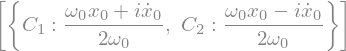

In [4]:
solved_ics = sympy.solve(ics)
solved_ics

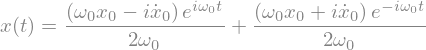

In [5]:
full_sol = sol.subs(solved_ics[0])
full_sol

The above equation was obtained by sympy and contains the solution to our problem. We can notice that it features complex exponentials, hinting at the oscillatory functions we already expect from our physical knowledge of harmonic oscillator.

Let's plot the solution for two different initial condition sets: 

- case 1 : initial position is non-zero and initial velocity is zero 
- case 2 : initial position is zero and initial velocity is non-zero

We'll use a value of $\omega_0$ equal to 2 (it's often helpful to not choose a value of 1 for constants to spot mistakes early).

In [6]:
case1 = sympy.simplify(full_sol.subs({x_0:1, xdot_0:0, omega_0:2}))
case1

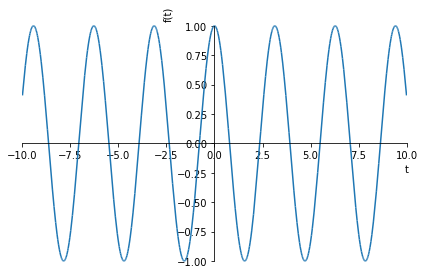

In [7]:
sympy.plot(case1.rhs)

Let's look at our second solution.

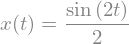

In [8]:
case2 = sympy.simplify(full_sol.subs({x_0:0, xdot_0:1, omega_0:2}))
case2

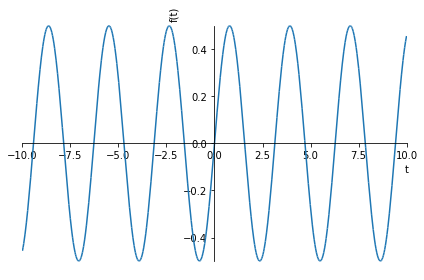

In [9]:
sympy.plot(case2.rhs)

Okay, now on to numerical solving with our own solution.

# Numerical solution using finite differences

Let's discretize our problem as an explicite [finite difference scheme](https://en.wikipedia.org/wiki/Finite_difference_method). The problem becomes:

$$
\left\{
\begin{align}
x^{n+1} = && (2 - \omega_0^2dt^2)x^n - x^{n-1} \\
x^0 = && x_0 \\
x^1 = && x_0 + \dot{x}_0 dt
\end{align}
\right.
$$

As we can see from the equation above, we need to keep track of the two previous positions $x^n$ and $x^{n-1}$ to compute the solution for the next time step. Also, the value $x^1$ is computed from the knowledge of the initial speed by a first order Taylor approximation.


To solve this, I wrote a class in the next cell called `HarmonicOdeSolver`. It provides two methods, apart from `__init__`:

- `step` that iterates the numerical system one single step in time
- `step_until` that iterates the numerical system until a given time and returns snapshots of the solution at certain points chosen by the user


In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

class HarmonicOdeSolver:
    def __init__(self, dt, x0, xd0, omega_squared):
        "Inits the solver."
        self.dt = dt
        self.dt_squared = dt**2
        self.t = dt
        self.omega_squared = omega_squared
        self.x0 = x0
        self.xd0 = xd0
        self.x = [xd0 * dt + x0, x0]
        
    def step(self):
        "Steps the solver."
        xt, xtm1 = self.x
        xtp1 = (2 - self.omega_squared * self.dt_squared) * xt - xtm1
        self.x = (xtp1, xt)
        self.t += self.dt
        
    def step_until(self, tmax, snapshot_dt):
        "Steps the solver until a given time, returns snapshots."
        ts = [self.t]
        vals = [self.x[0]]
        niter = max(1, int(snapshot_dt // self.dt))
        while self.t < tmax:
            for _ in range(niter):
                self.step()
            vals.append(self.x[0])
            ts.append(self.t)
        return np.array(ts), np.array(vals)

Let's test this implementation.

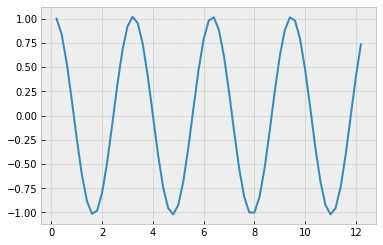

In [11]:
snapshot_dt = 0.15

solver = HarmonicOdeSolver(2e-1, 1, 0, 4)

ts, vals = solver.step_until(12, snapshot_dt)

plt.plot(ts, vals);

Let's compare this to sympy.

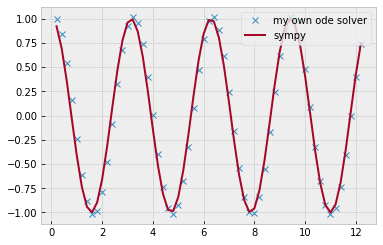

In [12]:
plt.plot(ts, vals, 'x', label='my own ode solver')
plt.plot(ts, sympy.lambdify(t, case1.rhs, 'numpy')(ts), label='sympy')
plt.legend(loc='upper right');

Okay, that's pretty good, except the ode solver lags a bit behind the sympy solution (this is due to the computation of $x^1$ that is a pretty bad approximation). Let's try again with a smaller `dt`.

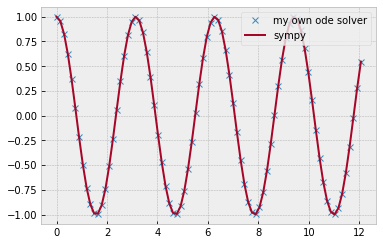

In [13]:
solver = HarmonicOdeSolver(1e-3, 1, 0, 4)

ts, vals = solver.step_until(12, snapshot_dt)

plt.plot(ts, vals, 'x', label='my own ode solver')
plt.plot(ts, sympy.lambdify(t, case1.rhs, 'numpy')(ts), label='sympy')
plt.legend(loc='upper right');

Okay, looks good. What about the second case?

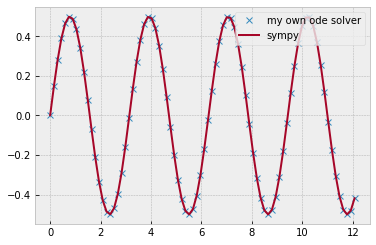

In [14]:
solver = HarmonicOdeSolver(1e-3, 0, 1, 4)
ts, vals = solver.step_until(12, snapshot_dt)

plt.plot(ts, vals, 'x', label='my own ode solver')
plt.plot(ts, np.real(sympy.lambdify(t, case2.rhs, 'numpy')(ts)), label='sympy')
plt.legend(loc='upper right');

Okay, good again!
Let's move on to the last part of this exploration.

# Numerical solution using Scipy 

Scipy offers a number of tools for dealing with ordinary differential equations: <https://docs.scipy.org/doc/scipy-0.18.1/reference/integrate.html>. 
Here, we'll use the [`odeint`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) routine.

The documentation says that this routine solves first order differential equations. This means that we need to recast our problem as a first order system. To do this, we write out a vector of unknowns:

$$
u = 
\begin{pmatrix}
\dot{x} \\
x
\end{pmatrix}
$$

Hence we can write:

$$
\frac{d}{dt}
\begin{pmatrix}
\dot{x} \\ x
\end{pmatrix} =
\begin{pmatrix}
-\omega_0^2 x \\ \dot{x}
\end{pmatrix}
$$


We can now write out the derivative, or the right hand side of the previous equation assuming we give our vector $u$ as input:

In [15]:
def deriv(u, t, omega_squared):
    "Provides derivative of vector u."
    xdot, x = u
    return [-omega_squared * x, xdot]

Let's solve case 1 using this. We define a time vector.

In [16]:
ts = np.arange(0, 12, snapshot_dt)

And initial conditions.

In [17]:
y0 = [0, 1]

Now we integrate and look at the result.

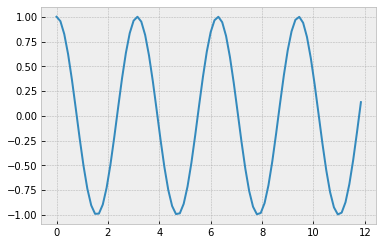

In [18]:
from scipy.integrate import odeint
scipysol = odeint(deriv, y0, ts, args=(4,))

plt.plot(ts, scipysol[:, 1]);

Let's compare it again with our reference solution:

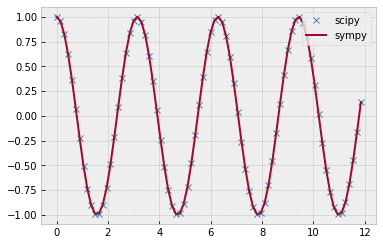

In [19]:
plt.plot(ts, scipysol[:, 1], 'x', label='scipy')
plt.plot(ts, sympy.lambdify(t, case1.rhs, 'numpy')(ts), label='sympy')
plt.legend(loc='upper right');

This works nicely. What about the second test case?

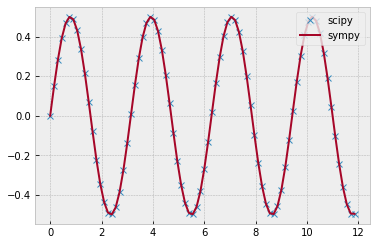

In [20]:
y0 = [1, 0]

scipysol = odeint(deriv, y0, ts, args=(4,))

plt.plot(ts, scipysol[:, 1], 'x', label='scipy')
plt.plot(ts, np.real(sympy.lambdify(t, case2.rhs, 'numpy')(ts)), label='sympy')
plt.legend(loc='upper right');

# Conclusions 

In this article, we've solved an ordinary differential equation in three different ways. First, we solved it exactly using an analytical approach (for which sympy did all the heavy lifting). Then, we implemented our own finite difference scheme. Finally, we used one of the builtin solvers of scipy to solve the equation. What we can say is:

- analytical solutions, when available, are the most useful
- implementing our own scheme is doable, but is a lot of work if we're not specialists in numerical computation and likely more complex in cases that are not like this one-dimensional oscillator
- using scipy is definitely recommended since all the complicated things from the finite differences are done for us (this strategy could be described as ["standing on the shoulders of giants"](https://en.wikipedia.org/wiki/Standing_on_the_shoulders_of_giants)) 

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170414_HarmonicOscillator.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170414_HarmonicOscillator.ipynb).*